In [21]:
!pip install nltk
!pip install textblob
!pip install wordcloud

In [22]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud

filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# 1. Text Preprocessing

In [23]:
df = pd.read_csv("datasets/amazon_reviews.csv")
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.00,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.00,best deal around,1373673600,2013-07-13,513,0,0


## Normalizing Case Folding

* Completing the uppercase and lowercase conversion to a certain standard

In [24]:
df['reviewText'] = df['reviewText'].str.lower()

In [25]:
df

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",no issues.,4.00,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","purchased this for my device, it worked as adv...",5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. i should have sprung for...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",this think has worked out great.had a diff. br...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","bought it with retail packaging, arrived legit...",5.00,best deal around,1373673600,2013-07-13,513,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4910,A2LBMKXRM5H2W9,B007WTAJTO,"ZM ""J""","[0, 0]",i bought this sandisk 16gb class 10 to use wit...,1.00,Do not waste your money.,1374537600,2013-07-23,503,0,0
4911,ALGDLRUI1ZPCS,B007WTAJTO,Zo,"[0, 0]",used this for extending the capabilities of my...,5.00,Great item!,1377129600,2013-08-22,473,0,0
4912,A2MR1NI0ENW2AD,B007WTAJTO,Z S Liske,"[0, 0]",great card that is very fast and reliable. it ...,5.00,Fast and reliable memory card,1396224000,2014-03-31,252,0,0
4913,A37E6P3DSO9QJD,B007WTAJTO,Z Taylor,"[0, 0]",good amount of space for the stuff i want to d...,5.00,Great little card,1379289600,2013-09-16,448,0,0


* Variables/situations we would like to exclude from the work so we delete them from the text as they are considered to have no meaning:
    * Punctuation marks
    * Numbers without measured value
    * Stop words (for, is, that)
    * Rare words
    

**Regular Expression:** A special structure used to complete, capture and work on a certain pattern in textual expressions.

### Punctluation Removal

In [26]:
df['reviewText'] = df['reviewText'].str.replace('[^\w\s]', '')

In [27]:
df['reviewText']

0                                              no issues.
1       purchased this for my device, it worked as adv...
2       it works as expected. i should have sprung for...
3       this think has worked out great.had a diff. br...
4       bought it with retail packaging, arrived legit...
                              ...                        
4910    i bought this sandisk 16gb class 10 to use wit...
4911    used this for extending the capabilities of my...
4912    great card that is very fast and reliable. it ...
4913    good amount of space for the stuff i want to d...
4914    i've heard bad things about this 64gb micro sd...
Name: reviewText, Length: 4915, dtype: object

### Numbers Removal

In [28]:
df['reviewText'] = df['reviewText'].str.replace('\d', '')

In [29]:
df['reviewText']

0                                              no issues.
1       purchased this for my device, it worked as adv...
2       it works as expected. i should have sprung for...
3       this think has worked out great.had a diff. br...
4       bought it with retail packaging, arrived legit...
                              ...                        
4910    i bought this sandisk 16gb class 10 to use wit...
4911    used this for extending the capabilities of my...
4912    great card that is very fast and reliable. it ...
4913    good amount of space for the stuff i want to d...
4914    i've heard bad things about this 64gb micro sd...
Name: reviewText, Length: 4915, dtype: object

### Stop words

In [30]:
import nltk

nltk.download('stopwords')
sw = stopwords.words('english')

df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

df['reviewText']

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tokel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0                                                 issues.
1       purchased device, worked advertised. never muc...
2       works expected. sprung higher capacity. think ...
3       think worked great.had diff. bran 64gb card we...
4       bought retail packaging, arrived legit, orange...
                              ...                        
4910    bought sandisk 16gb class 10 use htc inspire, ...
4911    used extending capabilities samsung galaxy not...
4912    great card fast reliable. comes optional adapt...
4913    good amount space stuff want do, fits gopro. say?
4914    i've heard bad things 64gb micro sd card crapp...
Name: reviewText, Length: 4915, dtype: object

### Rare words

In [31]:
temp_df = pd.Series(' '.join(df['reviewText']).split()).value_counts()

temp_df

card                      3475
works                     1468
memory                    1182
sd                        1131
phone                     1113
                          ... 
waaaaaaay                    1
s3/ip4s/ip5!                 1
11-28-12*********after       1
total...                     1
steal!would                  1
Name: count, Length: 16998, dtype: int64

In [32]:
# save the words that are used less than 1 time in the dataset
drops = temp_df[temp_df <= 1]

drops

fine).                    1
cameras/laptop            1
invented                  1
ways,                     1
ram;                      1
                         ..
waaaaaaay                 1
s3/ip4s/ip5!              1
11-28-12*********after    1
total...                  1
steal!would               1
Name: count, Length: 10805, dtype: int64

In [33]:
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(x for x in x.split() if x not in drops))

df['reviewText']

0                                                 issues.
1       purchased device, worked advertised. never muc...
2       works expected. higher capacity. think made bi...
3       think worked 64gb card went south 3 one held p...
4       bought retail packaging, arrived legit, versio...
                              ...                        
4910    bought sandisk 16gb class 10 use htc 3 months,...
4911    used capabilities samsung galaxy note 10. grea...
4912    great card fast reliable. comes optional adapt...
4913    good amount space stuff want do, fits gopro. say?
4914    i've heard bad things 64gb micro sd card crapp...
Name: reviewText, Length: 4915, dtype: object

## Tokenization

Tokenization in the context of natural language processing (NLP) refers to the process of breaking down text into smaller units, typically words or sentences. It’s a crucial first step in many NLP tasks, such as text analysis, machine translation, and sentiment analysis.

Here's what tokenization means in different contexts:

1. **Word Tokenization**:
   - **Definition**: Splitting a sentence or text into individual words.
   - **Example**: "The quick brown fox jumps over the lazy dog."
     - After tokenization: `["The", "quick", "brown", "fox", "jumps", "over", "the", "lazy", "dog"]`

2. **Sentence Tokenization**:
   - **Definition**: Splitting text into individual sentences.
   - **Example**: "Hello world. This is ChatGPT."
     - After tokenization: `["Hello world.", "This is ChatGPT."]`

3. **Subword Tokenization**:
   - **Definition**: Splitting words into smaller units, especially useful for handling unknown words or languages with rich morphology.
   - **Example**: The word "tokenization" might be broken down into `["token", "ization"]`.

### Sorting in Tokenization
If by "sort," you mean arranging the tokens in a specific order (e.g., alphabetical order), that’s different from the standard tokenization process. Sorting tokens can be done after tokenization for tasks like creating a vocabulary list, indexing, or searching.

- **Example**: Alphabetical sorting of tokens
  - Tokens: `["jumps", "brown", "dog", "quick"]`
  - After sorting: `["brown", "dog", "jumps", "quick"]`

### Summary
- **Tokenization**: Breaking text into smaller pieces like words or sentences.
- **Sorting**: Arranging those tokens in a specific order, typically done after tokenization if needed. 

Let me know if you were referring to a specific type of sorting or another aspect of tokenization!

In [34]:
import nltk
from textblob import TextBlob

# Download the necessary NLTK corpora
nltk.download('punkt', force=True)
nltk.download('averaged_perceptron_tagger')

# Now apply the TextBlob processing
df['reviewText'].apply(lambda x: TextBlob(x).words).head()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tokel\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\tokel\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


MissingCorpusError: 
Looks like you are missing some required data for this feature.

To download the necessary data, simply run

    python -m textblob.download_corpora

or use the NLTK downloader to download the missing data: http://nltk.org/data.html
If this doesn't fix the problem, file an issue at https://github.com/sloria/TextBlob/issues.


## Lemmatization

Separating words into their roots. For example, -s, -ing, etc. in words. remove word suffixes.

In [ ]:
nltk.download('wordnet')

df['reviewText'] = df['reviewText'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tokel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
df['reviewText']

0                                                 issues.
1       purchased device, worked advertised. never muc...
2       work expected. higher capacity. think made bit...
3       think worked 64gb card went south 3 one held p...
4       bought retail packaging, arrived legit, versio...
                              ...                        
4910    bought sandisk 16gb class 10 use htc 3 months,...
4911    used capability samsung galaxy note 10. greatl...
4912    great card fast reliable. come optional adapte...
4913     good amount space stuff want do, fit gopro. say?
4914    i've heard bad thing 64gb micro sd card crappi...
Name: reviewText, Length: 4915, dtype: object

# 2. Text Visualization

## Calculation of Term Frequencies

In [35]:
tf = df["reviewText"].fillna('').apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()


In [36]:
tf.columns = ['words', 'tf']

In [37]:
tf

,words,tf
0,issues.,115.00
1,purchased,331.00
2,"device,",38.00
3,worked,436.00
4,advertised.,49.00
...,...,...
6189,archive,2.00
6190,pureview,3.00
6191,laptop/tablet.,2.00
6192,sandisk:sequential,2.00


In [38]:
tf.sort_values("tf", ascending=False)

,words,tf
26,card,3475.00
15,works,1468.00
110,memory,1182.00
47,sd,1131.00
7,phone,1113.00
...,...,...
4217,"transcend,",2.00
4218,debating,2.00
4226,ss,2.00
6193,4.9,2.00


## Bar Plot

In [39]:
tf[tf["tf"] > 500] # words that are used more than 500 times in the dataset

,words,tf
7,phone,1113.00
15,works,1468.00
26,card,3475.00
37,one,916.00
43,bought,821.00
47,sd,1131.00
49,get,526.00
50,price,548.00
54,cards,655.00
74,sandisk,1104.00


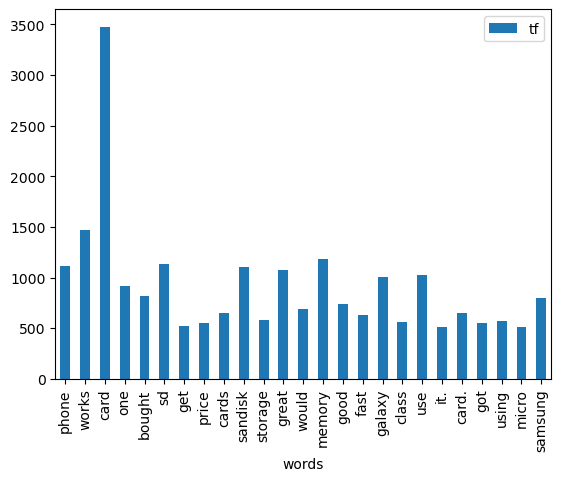

In [41]:
tf[tf["tf"] > 500].plot.bar(x="words", y="tf")
plt.show()

## Word Cloud

A word cloud is a visual display of text where the size of each word reflects its frequency or importance in the text. More frequent words appear larger, helping to quickly identify key themes or topics.

In [43]:
text = " ".join(i for i in df.reviewText)

In [44]:
text

'issues. purchased device, worked advertised. never much phone memory, since download lot stuff brainer me. works expected. higher capacity. think made bit earlier paint looks clean think worked 64gb card went south 3 one held pretty well since s3, update months zero since transferred s3 note2. card reliable bought retail packaging, arrived legit, version asian like picture shows. arrived quickly, bought 32 16 retail packaging htc one lg cards working probably best price get nice sd card mini storage. anything else supposed to. purchased add additional storage microsoft surface pro tablet come 64 128 gb. supposed sandisk long standing reputation speaks itself. phone never skips beat. file transfers speedy corruption issues memory issues would expect sandisk brand. great card own. precious files slightly cheaper piece lose everything spending extra couple bucks trusted product goes good hard believe affordable digital 32 gb device one quarter postage would less generation picked portabl

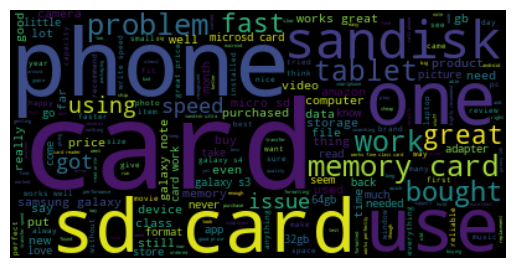

In [45]:
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

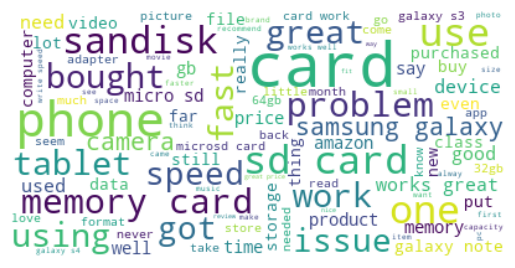

In [47]:
wordcloud = WordCloud(max_font_size=50, 
                      max_words=100, 
                      background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

wordcloud.to_file("wordcloud.png")

## Wordcloud by Templates

The process of combining word cloud and templates

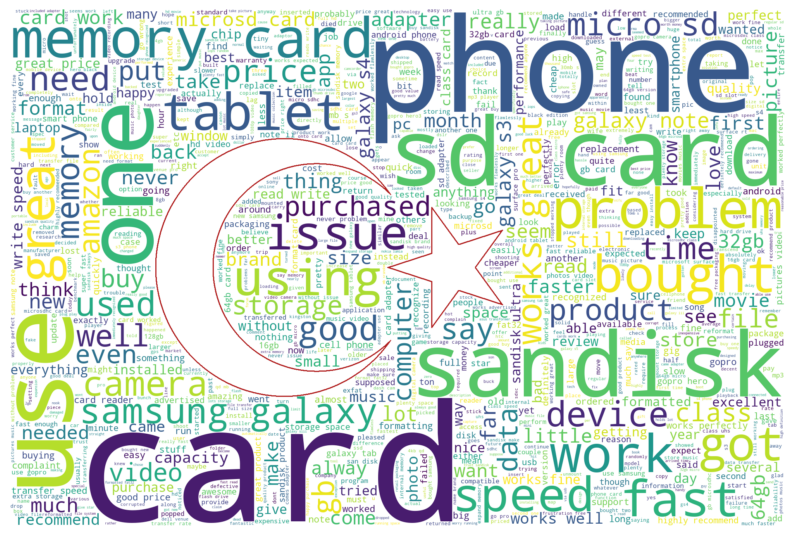

In [49]:
tr_mask = np.array(Image.open("turkish_flag.png"))

wc = WordCloud(background_color="white", 
               max_words=1000, mask=tr_mask, 
               contour_width=3, 
               contour_color='firebrick')
wc.generate(text)
plt.figure(figsize=[10, 10])
plt.imshow(wc, interpolation='bilinear')
plt.axis('off') 
plt.show()

wordcloud.to_file("turkish_flag_wordcloud.png")

# 3. Sentiment Modeling